In [1]:
# define libraries to use
import pandas as pd
import numpy as np
from pathlib import Path
import requests,json
import matplotlib.pyplot as plt

# variables that need initialization

# dict of dataframes
# FARS
farsDf = {}
# CRRS
crssDf = {}
# NY state vehicle registrations
nydmvDf = None

# Main Table
farsMainTbl = "accident"
farsKey = "ST_CASE"
crssMainTbl = "accident"
crssKey = "CASENUM"

def bulkreadcsv2df(myFolder, printProgress = False, lowMemory = True):
    """read each csv file in a folder into a df, each df added to as a separate dictionary entry with index a filename"""
    p = Path(myFolder)
    resDct = {}
    fileList = list(p.glob("*.CSV")) + list(p.glob("*.csv"))
    # sort file list based on stem of filename in lowercase
    fileList = sorted(fileList,key=lambda ppath: str(ppath.stem).lower())
    for myFile in fileList:
        dfName = myFile.stem.lower()
        if printProgress:
            print("Reading ",dfName)
        resDct[dfName] = pd.read_csv(str(myFile),encoding = 'unicode_escape', low_memory=lowMemory)

    return resDct



In [2]:
farsDf = bulkreadcsv2df("data/FARS2020NationalCSV/", lowMemory= False)
crssDf = bulkreadcsv2df("data/CRSS2020CSV/", lowMemory= False)
nydmvDf = pd.read_csv("data/nydmv/nydmv.csv",encoding = "unicode_escape", low_memory=False)

print("FARS Tables = ",list(farsDf.keys()))
print("CRSS Tables = ",list(crssDf.keys()))

FARS Tables =  ['accident', 'cevent', 'crashrf', 'damage', 'distract', 'drimpair', 'driverrf', 'drugs', 'factor', 'maneuver', 'miacc', 'midrvacc', 'miper', 'nmcrash', 'nmdistract', 'nmimpair', 'nmprior', 'parkwork', 'pbtype', 'person', 'personrf', 'pvehiclesf', 'race', 'safetyeq', 'vehicle', 'vehiclesf', 'vevent', 'violatn', 'vision', 'vpicdecode', 'vpictrailerdecode', 'vsoe', 'weather']
CRSS Tables =  ['accident', 'cevent', 'crashrf', 'damage', 'distract', 'drimpair', 'driverrf', 'factor', 'maneuver', 'nmcrash', 'nmdistract', 'nmimpair', 'nmprior', 'parkwork', 'pbtype', 'person', 'personrf', 'pvehiclesf', 'safetyeq', 'vehicle', 'vehiclesf', 'vevent', 'violatn', 'vision', 'vpicdecode', 'vpictrailerdecode', 'vsoe', 'weather']


In [3]:
print("                               F    A    R    S                                                           ")
for idx in farsDf.keys():
    print("==========================================================================================================")
    print("=                                                                                                        =")
    print("=",idx)
    farsDf[idx].info()
    print("=                                                                                                        =")
    print("==========================================================================================================")


                               F    A    R    S                                                           
=                                                                                                        =
= accident
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35766 entries, 0 to 35765
Data columns (total 81 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   STATE         35766 non-null  int64  
 1   STATENAME     35766 non-null  object 
 2   ST_CASE       35766 non-null  int64  
 3   VE_TOTAL      35766 non-null  int64  
 4   VE_FORMS      35766 non-null  int64  
 5   PVH_INVL      35766 non-null  int64  
 6   PEDS          35766 non-null  int64  
 7   PERSONS       35766 non-null  int64  
 8   PERMVIT       35766 non-null  int64  
 9   PERNOTMVIT    35766 non-null  int64  
 10  COUNTY        35766 non-null  int64  
 11  COUNTYNAME    35766 non-null  object 
 12  CITY          35766 non-null  int64  
 13  CITYNAME      35

In [4]:
print("                               C    R    S    S                                                           ")
for idx in crssDf.keys():
    print("==========================================================================================================")
    print("=                                                                                                        =")
    print("=",idx)
    crssDf[idx].info()
    print("=                                                                                                        =")
    print("==========================================================================================================")


                               C    R    S    S                                                           
=                                                                                                        =
= accident
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54745 entries, 0 to 54744
Data columns (total 80 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CASENUM         54745 non-null  int64  
 1   STRATUM         54745 non-null  int64  
 2   STRATUMNAME     54745 non-null  object 
 3   REGION          54745 non-null  int64  
 4   REGIONNAME      54745 non-null  object 
 5   PSU             54745 non-null  int64  
 6   PJ              54745 non-null  int64  
 7   PSU_VAR         54745 non-null  int64  
 8   URBANICITY      54745 non-null  int64  
 9   URBANICITYNAME  54745 non-null  object 
 10  VE_TOTAL        54745 non-null  int64  
 11  VE_FORMS        54745 non-null  int64  
 12  PVH_INVL        54745 non-null 

# FARS Table Cleanup to reduce to columns of interest and remove redundant data

## Create Categorical variables based on data

Pandas categorical data type not used so as to keep the original category codes

In [5]:
# farsCategories will hold the categorical mappings for categorical colums

farsCategories = {}

farsCategoricalColumns = {
    "accident" : [
        ["STATE","STATENAME"],
        ["MONTH","MONTHNAME"],
        ["DAY_WEEK","DAY_WEEKNAME"],
        ["ROUTE","ROUTENAME"],
        ["RUR_URB","RUR_URBNAME"],
        ["FUNC_SYS","FUNC_SYSNAME"],
        ["HARM_EV","HARM_EVNAME"],
        ["MAN_COLL","MAN_COLLNAME"],
        #["RELJCT1","RELJCT1NAME"],
        ["LGT_COND","LGT_CONDNAME"],
        ["WEATHER","WEATHERNAME"]
    ],
    "vehicle" : [
        ["NUMOCCS","NUMOCCSNAME"],
        ["MAKE","MAKENAME"],
        ["MAK_MOD","MAK_MODNAME"],
        ["BODY_TYP","BODY_TYPNAME"],
        ["TOW_VEH","TOW_VEHNAME"],
        ["TRAV_SP","TRAV_SPNAME"],
        ["ROLLOVER","ROLLOVERNAME"],
        ["M_HARM","M_HARMNAME"],
        ["DR_PRES","DR_PRESNAME"],
        ["L_STATUS","L_STATUSNAME"],
        ["L_TYPE","L_TYPENAME"],
        ["PREV_ACC","PREV_ACCNAME"],
        ["PREV_DWI","PREV_DWINAME"],
        ["PREV_SPD","PREV_SPDNAME"],
        ["PREV_OTH","PREV_OTHNAME"],
        ["SPEEDREL","SPEEDRELNAME"],
        ["VSURCOND","VSURCONDNAME"],
        ["P_CRASH2","P_CRASH2NAME"],
        ["ACC_TYPE","ACC_TYPENAME"],
        ["DR_DRINK","DR_DRINKNAME"]
    ],
    "person" : [
        ["SEX","SEXNAME"],
        ["PER_TYP","PER_TYPNAME"],
        ["INJ_SEV","INJ_SEVNAME"],
        ["SEAT_POS","SEAT_POSNAME"],
        ["REST_USE","REST_USENAME"],
        ["AIR_BAG","AIR_BAGNAME"],
        ["EJECTION","EJECTIONNAME"],
        ["LOCATION","LOCATIONNAME"]
    ],
    "parkwork" : [
		["PNUMOCCS","PNUMOCCSNAME"],
		["PTYPE","PTYPENAME"],
		["PMAKE","PMAKENAME"],
		["PMAK_MOD","PBODYTYP"],
		["PTRAILER","PTRAILERNAME"],
		["PM_HARM","PM_HARMNAME"],
    ],
    "pbtype" : [
        ["PBPTYPE","PBPTYPENAME"],
        ["PBAGE","PBAGENAME"],
        ["PBSEX","PBSEXNAME"],
    ],
    "vevent" : [
        ["AOI1","AOI1NAME"],
        ["AOI2","AOI2NAME"],
    ],
    "crashrf" : [
        ["CRASHRF","CRASHRFNAME"],
    ],
    "driverrf" : [
        ["DRIVERRF","DRIVERRFNAME"],
    ],
    "distract" : [
        ["DRDISTRACT","DRDISTRACTNAME"],
    ],
    "drimpair" : [
        ["DRIMPAIR", "DRIMPAIRNAME"],
    ],
    "factor" : [
        ["VEHICLECC","VEHICLECCNAME"],
    ],
    "vision" : [
        ["VISION", "VISIONNAME"],
    ],
    "nmcrash" : [
        ["NMCC","NMCCNAME"],
    ], 
}

for dataFile in farsCategoricalColumns.keys():
    print(dataFile, "======================================")
    for catCol in farsCategoricalColumns[dataFile]:
        print(catCol, end=",")
        farsCategories[catCol[0]] = dict(np.array(farsDf[dataFile][catCol].drop_duplicates()))
    print()



accident ======================================
['STATE', 'STATENAME'],['MONTH', 'MONTHNAME'],['DAY_WEEK', 'DAY_WEEKNAME'],['ROUTE', 'ROUTENAME'],['RUR_URB', 'RUR_URBNAME'],['FUNC_SYS', 'FUNC_SYSNAME'],['HARM_EV', 'HARM_EVNAME'],['MAN_COLL', 'MAN_COLLNAME'],['LGT_COND', 'LGT_CONDNAME'],['WEATHER', 'WEATHERNAME'],
vehicle ======================================
['NUMOCCS', 'NUMOCCSNAME'],['MAKE', 'MAKENAME'],['MAK_MOD', 'MAK_MODNAME'],['BODY_TYP', 'BODY_TYPNAME'],['TOW_VEH', 'TOW_VEHNAME'],['TRAV_SP', 'TRAV_SPNAME'],['ROLLOVER', 'ROLLOVERNAME'],['M_HARM', 'M_HARMNAME'],['DR_PRES', 'DR_PRESNAME'],['L_STATUS', 'L_STATUSNAME'],['L_TYPE', 'L_TYPENAME'],['PREV_ACC', 'PREV_ACCNAME'],['PREV_DWI', 'PREV_DWINAME'],['PREV_SPD', 'PREV_SPDNAME'],['PREV_OTH', 'PREV_OTHNAME'],['SPEEDREL', 'SPEEDRELNAME'],['VSURCOND', 'VSURCONDNAME'],['P_CRASH2', 'P_CRASH2NAME'],['ACC_TYPE', 'ACC_TYPENAME'],['DR_DRINK', 'DR_DRINKNAME'],
person ======================================
['SEX', 'SEXNAME'],['PER_TYP', 'PER_T

In [6]:
# FARS non-categorical Columns

farsNumericalColumns = {
    "accident" : [
		"ST_CASE",
		"VE_TOTAL",
		"VE_FORMS",
		"PVH_INVL",
		"PEDS",
		"PERSONS",
		"PERMVIT",
		"PERNOTMVIT",
		"DAY",
		"YEAR",
		"HOUR",
		"MINUTE",
		"FATALS",
    ],
    "vehicle" : [
		"ST_CASE",
		"VEH_NO",
		"MOD_YEAR",
		"VIN",
		"DEATHS",
    ],
    "person" : [
		"ST_CASE",
		"VEH_NO",
		"PER_NO",
		"STR_VEH",
		"AGE",
    ],
    "parkwork" : [
		"ST_CASE",
		"VEH_NO",
		"PBODYTYPNAME",
		"PMODYEAR",
		"PVIN",
		"PDEATHS",
    ],
    "pbtype" : [
		"ST_CASE",
		"VEH_NO",
		"PER_NO",
    ],
    "vevent" : [
		"ST_CASE",
		"VEH_NO",
		"VEVENTNUM",
		"VNUMBER1",
		"VNUMBER2",
		"VNUMBER2NAME",
    ],
    "crashrf" : [
		"ST_CASE",
    ],
    "driverrf" : [
		"ST_CASE",
		"VEH_NO",
    ],
    "distract" : [
		"ST_CASE",
		"VEH_NO",
    ],
    "drimpair" : [
		"ST_CASE",
		"VEH_NO",
    ],
    "factor" : [
		"ST_CASE",
		"VEH_NO",
    ],
    "vision" : [
		"ST_CASE",
		"VEH_NO",
    ],
    "nmcrash" : [
		"ST_CASE",
		"VEH_NO",
		"PER_NO",
    ], 
} 

# Drop all columns except chosen ones
for dataFile in farsNumericalColumns.keys():
	print(dataFile, "======================================")
	# all columns
	columnSet = set(farsDf[dataFile].columns)
	for catCol in farsCategoricalColumns[dataFile]:
		# remove categorical index column so that it is preserved (not dropped)
		columnSet.remove(catCol[0])
	for catCol in farsNumericalColumns[dataFile]:
		# remove numerical column we want to preserve (not dropped)
		columnSet.remove(catCol)
	# remove unwanted columns
	farsDf[dataFile].drop(columns = columnSet,inplace = True)
	print(farsDf[dataFile].columns)

accident ======================================
Index(['STATE', 'ST_CASE', 'VE_TOTAL', 'VE_FORMS', 'PVH_INVL', 'PEDS',
       'PERSONS', 'PERMVIT', 'PERNOTMVIT', 'DAY', 'MONTH', 'YEAR', 'DAY_WEEK',
       'HOUR', 'MINUTE', 'ROUTE', 'RUR_URB', 'FUNC_SYS', 'HARM_EV', 'MAN_COLL',
       'LGT_COND', 'WEATHER', 'FATALS'],
      dtype='object')
vehicle ======================================
Index(['ST_CASE', 'VEH_NO', 'NUMOCCS', 'MAKE', 'MAK_MOD', 'BODY_TYP',
       'MOD_YEAR', 'VIN', 'TOW_VEH', 'TRAV_SP', 'ROLLOVER', 'M_HARM',
       'DR_PRES', 'L_STATUS', 'L_TYPE', 'PREV_ACC', 'PREV_DWI', 'PREV_SPD',
       'PREV_OTH', 'SPEEDREL', 'VSURCOND', 'P_CRASH2', 'ACC_TYPE', 'DEATHS',
       'DR_DRINK'],
      dtype='object')
person ======================================
Index(['ST_CASE', 'VEH_NO', 'PER_NO', 'STR_VEH', 'AGE', 'SEX', 'PER_TYP',
       'INJ_SEV', 'SEAT_POS', 'REST_USE', 'AIR_BAG', 'EJECTION', 'LOCATION'],
      dtype='object')
parkwork ======================================
Index(['S

In [7]:
#pd.DataFrame(farsCategories["HARM_EV"],columns=["id","name"]).to_csv("HARM_EV.csv")

# add simplified HARM_EV category HARM_EV_SIMP, and simplified PHARM_EV_SIMP
farsCategories["HARM_EV_SIMP"] = dict(
    [
        [1,"Animal"],
	    [2,"Building"],
	    [3,"Fixed object"],
	    [4,"Jackknife"],
	    [5,"Motor Vehicle In-Transport"],
	    [6,"Non-Collision"],
	    [7,"Non-Motorist on Personal Conveyance"],
	    [8,"Object not-fixed"],
	    [9,"Parked Motor Vehicle"],
	    [10,"Road Surface"],
	    [11,"Pedalcyclist"],
	    [12,"Pedestrian"],
	    [13,"Railway Vehicle"],
	    [14,"Rollover/Overturn"],
	    [15,"Snow Bank"],
	    [16,"Traffic Barrier"],
	    [17,"Working Motor Vehicle"],
	    [99,"Unknown"]
    ]
)
#farsCategories["PHARM_EV_SIMP"] = farsCategories["HARM_EV_SIMP"].copy()

# HARM_EV mapping to HARM_EV_SIMP
harmEvSimpMap = {
	1 : 14,
	2 : 6,
	3 : 6,
	5 : 6,
	6 : 6,
	7 : 6,
	8 : 12,
	9 : 11,
	10 : 13,
	11 : 1,
	12 : 5,
	14 : 9,
	15 : 7,
	16 : 8,
	17 : 8,
	18 : 8,
	19 : 2,
	20 : 16,
	21 : 16,
	23 : 16,
	24 : 16,
	25 : 16,
	26 : 16,
	30 : 3,
	31 : 3,
	32 : 3,
	33 : 3,
	34 : 3,
	35 : 3,
	38 : 3,
	39 : 3,
	40 : 3,
	41 : 3,
	42 : 3,
	43 : 3,
	44 : 10,
	45 : 17,
	46 : 16,
	48 : 15,
	49 : 1,
	50 : 16,
	51 : 4,
	52 : 16,
	53 : 3,
	54 : 5,
	55 : 5,
	57 : 3,
	58 : 10,
	59 : 3,
	72 : 8,
	73 : 8,
	74 : 13,
	91 : 8,
	93 : 3,
	98 : 99,
	99 : 99,
}

# new columns based on mappings
farsDf["accident"]["HARM_EV_SIMP"] = farsDf["accident"].apply(lambda row: harmEvSimpMap[row["HARM_EV"]],axis=1)
farsDf["parkwork"]["PM_HARM_SIMP"] = farsDf["parkwork"].apply(lambda row: harmEvSimpMap[row["PM_HARM"]],axis=1)

In [8]:
farsDf["accident"].describe(include="all")

,STATE,ST_CASE,VE_TOTAL,VE_FORMS,PVH_INVL,PEDS,PERSONS,PERMVIT,PERNOTMVIT,DAY,...,MINUTE,ROUTE,RUR_URB,FUNC_SYS,HARM_EV,MAN_COLL,LGT_COND,WEATHER,FATALS,HARM_EV_SIMP
count,35766.000000,35766.000000,35766.000000,35766.000000,35766.000000,35766.000000,35766.000000,35766.000000,35766.000000,35766.000000,...,35766.000000,35766.000000,35766.000000,35766.000000,35766.000000,35766.000000,35766.000000,35766.000000,35766.000000,35766.000000
mean,27.158307,272387.092937,1.560113,1.517419,0.042694,0.228485,2.172818,2.162585,0.238718,15.705139,...,29.241123,3.901079,1.662025,6.038193,18.311357,1.928927,1.961052,9.724683,1.085500,7.306856
std,16.354713,163438.330390,0.782449,0.736814,0.292877,0.470604,1.593437,1.589051,0.494223,8.820912,...,18.540796,2.291921,0.894967,14.282173,14.440480,6.235890,1.222222,25.543251,0.342381,5.920611
min,1.000000,10001.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,12.000000,122077.500000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,8.000000,...,14.000000,2.000000,1.000000,3.000000,8.000000,0.000000,1.000000,1.000000,1.000000,3.000000
50%,26.000000,260916.500000,1.000000,1.000000,0.000000,0.000000,2.000000,2.000000,0.000000,16.000000,...,30.000000,3.000000,2.000000,4.000000,12.000000,0.000000,2.000000,1.000000,1.000000,5.000000
75%,42.000000,420476.750000,2.000000,2.000000,0.000000,0.000000,3.000000,3.000000,0.000000,23.000000,...,45.000000,6.000000,2.000000,5.000000,30.000000,2.000000,3.000000,2.000000,1.000000,12.000000
max,56.000000,560115.000000,15.000000,15.000000,10.000000,8.000000,61.000000,61.000000,9.000000,31.000000,...,99.000000,9.000000,9.000000,99.000000,99.000000,99.000000,9.000000,99.000000,8.000000,99.000000


In [9]:
farsDf["accident"].info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35766 entries, 0 to 35765
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   STATE         35766 non-null  int64
 1   ST_CASE       35766 non-null  int64
 2   VE_TOTAL      35766 non-null  int64
 3   VE_FORMS      35766 non-null  int64
 4   PVH_INVL      35766 non-null  int64
 5   PEDS          35766 non-null  int64
 6   PERSONS       35766 non-null  int64
 7   PERMVIT       35766 non-null  int64
 8   PERNOTMVIT    35766 non-null  int64
 9   DAY           35766 non-null  int64
 10  MONTH         35766 non-null  int64
 11  YEAR          35766 non-null  int64
 12  DAY_WEEK      35766 non-null  int64
 13  HOUR          35766 non-null  int64
 14  MINUTE        35766 non-null  int64
 15  ROUTE         35766 non-null  int64
 16  RUR_URB       35766 non-null  int64
 17  FUNC_SYS      35766 non-null  int64
 18  HARM_EV       35766 non-null  int64
 19  MAN_COLL      35766 non-n

# FARS Data Verification

In [49]:
totalAcc = len(farsDf["accident"])

In [10]:
accStatesDf = pd.DataFrame(farsDf["accident"]["STATE"].value_counts().sort_values(ascending=False).head(14))
accStatesDf.columns = ["TotalAcc"]
accStatesDf["STATE"] = accStatesDf.index.values
accStatesDf["STATE"] = accStatesDf.apply(lambda row: farsCategories["STATE"][row["STATE"]],axis=1)
accStatesDf.loc["Others"] = [farsDf["accident"]["STATE"].count() - accStatesDf["TotalAcc"].sum(),"Others"]
accStatesDf.set_index("STATE",inplace=True)
accStatesDf

,TotalAcc
STATE,
California,3558
Texas,3520
Florida,3098
Georgia,1522
North Carolina,1412
Ohio,1154
Tennessee,1119
Illinois,1087
Pennsylvania,1060


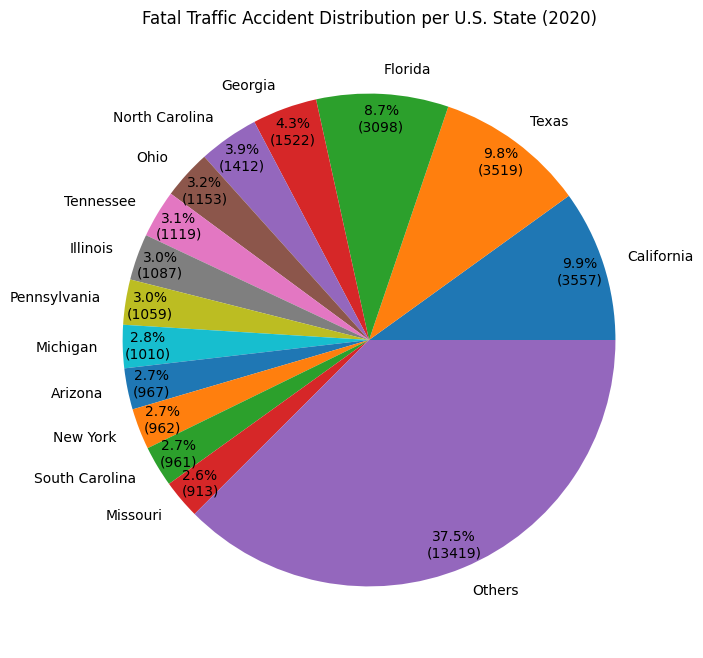

In [11]:

def func(pct):
    absolute = int(pct/100.*farsDf["accident"]["STATE"].count())
    return "{:.1f}%\n({:d})".format(pct, absolute)

#autopct = "%1.1f%%" if not using function

_ = accStatesDf.plot.pie(y="TotalAcc",figsize=(8,8),legend = False, title = "Fatal Traffic Accident Distribution per U.S. State (2020)", \
    ylabel = "", autopct=lambda pct: func(pct), pctdistance = 0.9, rotatelabels = False)



In [12]:
accTotalsDf = pd.DataFrame(dict(farsDf["accident"][["VE_TOTAL","VE_FORMS","PVH_INVL","PERSONS","PERMVIT","PERNOTMVIT","PEDS","FATALS"]].sum()),index = ["Total"])
accTotalsDf["Fatal Accidents"] = len(farsDf["accident"])
accTotalsDf["Occupants in Parked and Work Vehicles"] = accTotalsDf["PERNOTMVIT"] - accTotalsDf["PEDS"]
accTotalsDf = accTotalsDf.reindex(columns=['Fatal Accidents', 'VE_TOTAL', "VE_FORMS", 'PVH_INVL', 'PERSONS', 'PERMVIT', 'PERNOTMVIT', "Occupants in Parked and Work Vehicles",'PEDS','FATALS'])
accTotalsDf.columns = ['Total Fatal Accidents', 'Total Vehicles', "Vehicles in Transport",'Parked and Working Vehicles', 'Vehicle Occupants', 'Occupants in Vehicles in Transport', 'Persons Not in Motor Vehicles in Transport', "Occupants in Parked and Work Vehicles", 'Person not in Vehicles','Fatalities']
accTotalsDf

,Total Fatal Accidents,Total Vehicles,Vehicles in Transport,Parked and Working Vehicles,Vehicle Occupants,Occupants in Vehicles in Transport,Persons Not in Motor Vehicles in Transport,Occupants in Parked and Work Vehicles,Person not in Vehicles,Fatalities
Total,35766,55799,54272,1527,77713,77347,8538,366,8172,38824


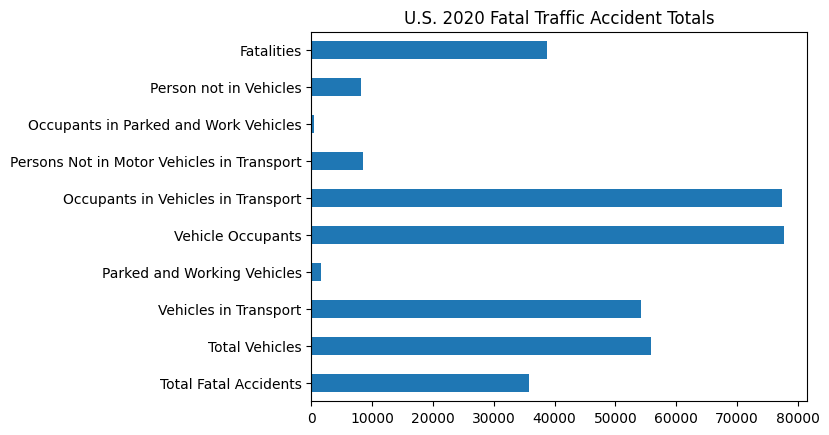

In [13]:
accTotalsSer = accTotalsDf.loc["Total"]
ax = accTotalsSer.plot.barh(title = "U.S. 2020 Fatal Traffic Accident Totals")

<AxesSubplot: title={'center': 'Vehicles in Transport vs Parked and Working Vehicles'}>

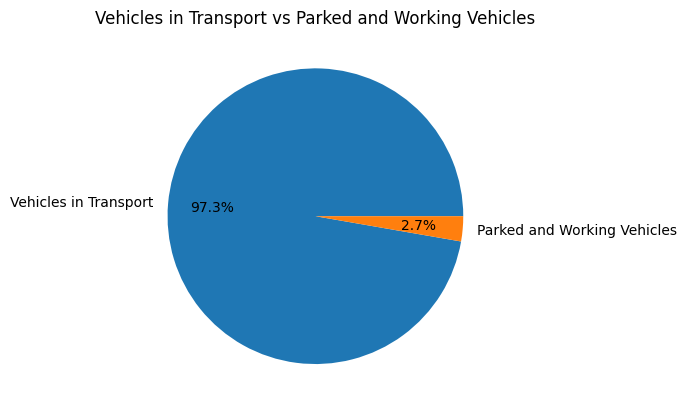

In [14]:
accTotalsDf.loc["Total"][["Vehicles in Transport",'Parked and Working Vehicles']].plot.pie(legend = False, title = "Vehicles in Transport vs Parked and Working Vehicles", \
    ylabel = "", autopct="%1.1f%%", pctdistance = 0.7, rotatelabels = False)

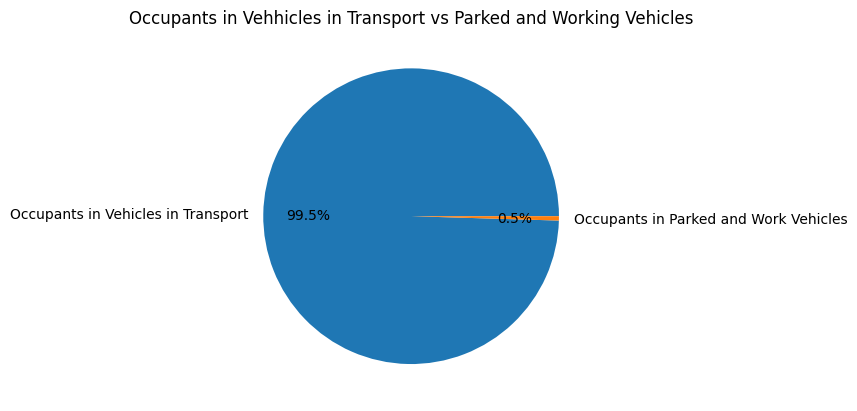

In [15]:
_ = accTotalsDf.loc["Total"][['Occupants in Vehicles in Transport',"Occupants in Parked and Work Vehicles"]].plot.pie(legend = False, title = "Occupants in Vehhicles in Transport vs Parked and Working Vehicles", \
    ylabel = "", autopct="%1.1f%%", pctdistance = 0.7, rotatelabels = False)

In [16]:
# accidents by month
accMonthDf = pd.DataFrame(farsDf["accident"]["MONTH"].value_counts()).sort_index()
accMonthDf.columns = ["TotalAcc"]
accMonthDf["MONTH"] = accMonthDf.index.values
accMonthDf["MONTH"] = accMonthDf.apply(lambda row: farsCategories["MONTH"][row["MONTH"]],axis=1)
#accMonthDf.loc["Others"] = [farsDf["accident"]["STATE"].count() - accMonthDf["TotalAcc"].sum(),"Others"]
accMonthDf.set_index("MONTH",inplace=True)
accMonthDf

,TotalAcc
MONTH,
January,2485
February,2450
March,2369
April,2127
May,2865
June,3374
July,3483
August,3523
September,3426


<AxesSubplot: title={'center': 'U.S. 2020 Fatal Traffic Accident per Month'}, xlabel='MONTH', ylabel='Total Falta Accidents'>

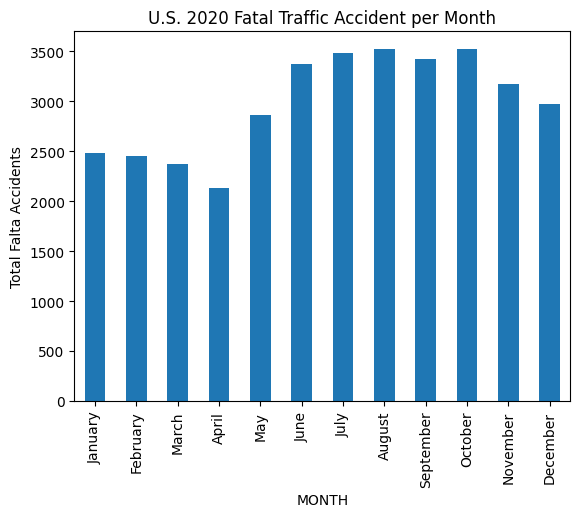

In [17]:
accMonthDf.plot.bar(title = "U.S. 2020 Fatal Traffic Accident per Month",legend = False, ylabel = "Total Falta Accidents")

In [18]:
# accidents by day of the week
accDayWeekDf = pd.DataFrame(farsDf["accident"]["DAY_WEEK"].value_counts()).sort_index()
accDayWeekDf.columns = ["TotalAcc"]
accDayWeekDf["DAY_WEEK"] = accDayWeekDf.index.values
accDayWeekDf["DAY_WEEK"] = accDayWeekDf.apply(lambda row: farsCategories["DAY_WEEK"][row["DAY_WEEK"]],axis=1)
#accMonthDf.loc["Others"] = [farsDf["accident"]["STATE"].count() - accMonthDf["TotalAcc"].sum(),"Others"]
accDayWeekDf.set_index("DAY_WEEK",inplace=True)
accDayWeekDf

,TotalAcc
DAY_WEEK,
Sunday,5591
Monday,4474
Tuesday,4521
Wednesday,4689
Thursday,4827
Friday,5502
Saturday,6162


<AxesSubplot: title={'center': 'U.S. 2020 Fatal Traffic Accident per Day of the Week'}, xlabel='Day of the Week', ylabel='Total Falta Accidents'>

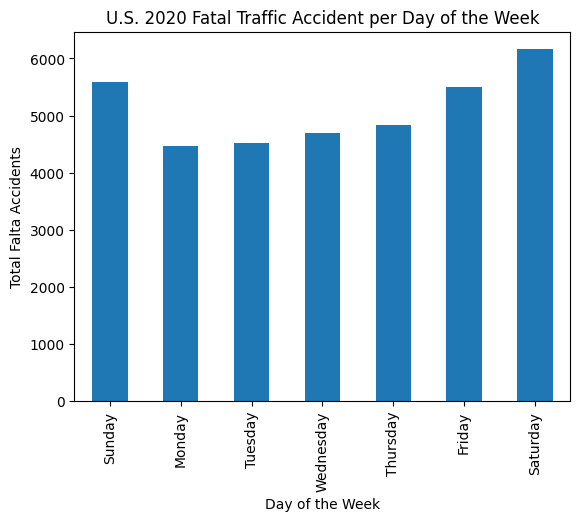

In [19]:
accDayWeekDf.plot.bar(title = "U.S. 2020 Fatal Traffic Accident per Day of the Week",legend = False, ylabel = "Total Falta Accidents", \
    xlabel = "Day of the Week")

In [20]:
# accidents and weather events
accWeatherDf = pd.DataFrame(farsDf["accident"]["WEATHER"].value_counts().sort_values(ascending=False))
accWeatherDf.columns = ["TotalAccidents"]
totalWeatherAcc = accWeatherDf["TotalAccidents"].sum()
accWeatherDf["WEATHER"] = accWeatherDf.index.values
accWeatherDf["WEATHER"] = accWeatherDf.apply(lambda row: farsCategories["WEATHER"][row["WEATHER"]],axis=1)
accWeatherDf.set_index("WEATHER",inplace=True)
# combined unknown and not reported rows
accWeatherDf.loc["Unknown"] = accWeatherDf.loc["Not Reported"] + accWeatherDf.loc["Reported as Unknown"]
accWeatherDf.drop(index=["Reported as Unknown","Not Reported"],inplace=True)
accWeatherDf

,TotalAccidents
WEATHER,
Clear,24963
Cloudy,4622
Rain,2634
"Fog, Smog, Smoke",370
Snow,283
Severe Crosswinds,56
Freezing Rain or Drizzle,39
Blowing Snow,26
Sleet or Hail,26


/var/folders/4d/pq_2_fgs7s3bjnxxpgksl2880000gn/T/ipykernel_44996/3199826246.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accWeatherDf.loc["Other"] = [totalWeatherAcc - accWeatherDf["TotalAccidents"].sum()]


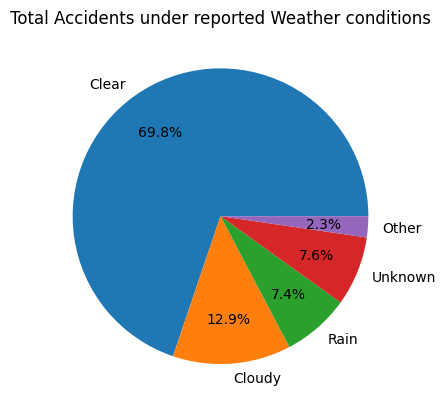

In [21]:
accWeatherDf = accWeatherDf[accWeatherDf["TotalAccidents"] > 2000]
accWeatherDf.loc["Other"] = [totalWeatherAcc - accWeatherDf["TotalAccidents"].sum()]
_ = accWeatherDf["TotalAccidents"].plot.pie(legend = False, title = "Total Accidents under reported Weather conditions", \
    ylabel = "", autopct="%1.1f%%", pctdistance = 0.7, rotatelabels = False)

In [22]:
# accidents and light condition
accLightDf = pd.DataFrame(farsDf["accident"]["LGT_COND"].value_counts().sort_values(ascending=False))
accLightDf.columns = ["TotalAccidents"]
totalAcc = accLightDf["TotalAccidents"].sum()
accLightDf["LGT_COND"] = accLightDf.index.values
accLightDf["LGT_COND"] = accLightDf.apply(lambda row: farsCategories["LGT_COND"][row["LGT_COND"]],axis=1)
accLightDf.set_index("LGT_COND",inplace=True)
# combined unknown and not reported rows
#accLightDf.loc["Unknown"] = accWeatherDf.loc["Not Reported"] + accWeatherDf.loc["Reported as Unknown"]
#accLightDf.drop(index=["Reported as Unknown","Not Reported"],inplace=True)
accLightDf

,TotalAccidents
LGT_COND,
Daylight,16291
Dark - Not Lighted,9827
Dark - Lighted,7407
Dusk,955
Dawn,650
Dark - Unknown Lighting,338
Reported as Unknown,203
Not Reported,78
Other,17


/var/folders/4d/pq_2_fgs7s3bjnxxpgksl2880000gn/T/ipykernel_44996/2954352009.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accLightDf.loc["Other"] = [totalAcc - accLightDf["TotalAccidents"].sum()]


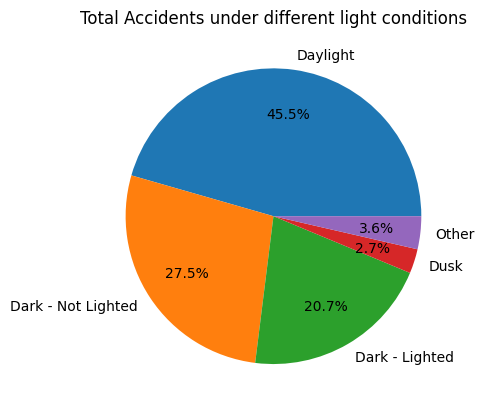

In [23]:
accLightDf = accLightDf[accLightDf["TotalAccidents"] > 900]
accLightDf.loc["Other"] = [totalAcc - accLightDf["TotalAccidents"].sum()]
_ = accLightDf["TotalAccidents"].plot.pie(legend = False, title = "Total Accidents under different light conditions", \
    ylabel = "", autopct="%1.1f%%", pctdistance = 0.7, rotatelabels = False)

In [24]:
# accidents harmul events
accHarmEvDf = pd.DataFrame(farsDf["accident"]["HARM_EV_SIMP"].value_counts().sort_values(ascending=False))
accHarmEvDf.columns = ["TotalAccidents"]
accHarmEvDf["HARM_EV_SIMP"] = accHarmEvDf.index.values
accHarmEvDf["HARM_EV_SIMP"] = accHarmEvDf.apply(lambda row: farsCategories["HARM_EV_SIMP"][row["HARM_EV_SIMP"]],axis=1)
#accMonthDf.loc["Others"] = [farsDf["accident"]["STATE"].count() - accMonthDf["TotalAcc"].sum(),"Others"]
accHarmEvDf.set_index("HARM_EV_SIMP",inplace=True)
totalAcc = accHarmEvDf["TotalAccidents"].sum()
accHarmEvDf

,TotalAccidents
HARM_EV_SIMP,
Motor Vehicle In-Transport,13645
Fixed object,8987
Pedestrian,5982
Rollover/Overturn,2694
Traffic Barrier,1651
Pedalcyclist,923
Parked Motor Vehicle,459
Object not-fixed,326
Non-Collision,298


/var/folders/4d/pq_2_fgs7s3bjnxxpgksl2880000gn/T/ipykernel_44996/2337594083.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accHarmEvDf.loc["Other"] = [totalAcc - accHarmEvDf["TotalAccidents"].sum()]


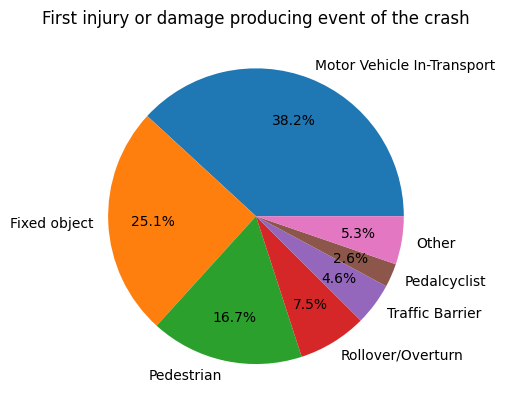

In [25]:
accHarmEvDf = accHarmEvDf[accHarmEvDf["TotalAccidents"] > 500]
accHarmEvDf.loc["Other"] = [totalAcc - accHarmEvDf["TotalAccidents"].sum()]
_ = accHarmEvDf["TotalAccidents"].plot.pie(legend = False, title = "First injury or damage producing event of the crash", \
    ylabel = "", autopct="%1.1f%%", pctdistance = 0.7, rotatelabels = False)

In [59]:
# for Events including Motort Vehicle in Transport orientation of montor vehicles
accManCollDf = pd.DataFrame(farsDf["accident"]["MAN_COLL"].value_counts().sort_values(ascending=False))
accManCollDf.columns = ["TotalAccidents"]
accManCollDf["MAN_COLL"] = accManCollDf.index.values
accManCollDf["MAN_COLL"] = accManCollDf.apply(lambda row: farsCategories["MAN_COLL"][row["MAN_COLL"]],axis=1)
#accMonthDf.loc["Others"] = [farsDf["accident"]["STATE"].count() - accMonthDf["TotalAcc"].sum(),"Others"]
accManCollDf.set_index("MAN_COLL",inplace=True)
accManCollDf.drop(index=["The First Harmful Event was Not a Collision with a Motor Vehicle in Transport"],inplace=True)
totMVinTransportAcc = accManCollDf["TotalAccidents"].sum()
accManCollDf

,TotalAccidents
MAN_COLL,
Angle,6432
Front-to-Front,3631
Front-to-Rear,2428
Sideswipe - Same Direction,530
Sideswipe - Opposite Direction,420
Other,101
Reported as Unknown,85
Not Reported,39
Rear-to-Side,30


/var/folders/4d/pq_2_fgs7s3bjnxxpgksl2880000gn/T/ipykernel_44996/3567835035.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accManCollDf.loc["Other"] = [totMVinTransportAcc - accManCollDf["TotalAccidents"].sum()]


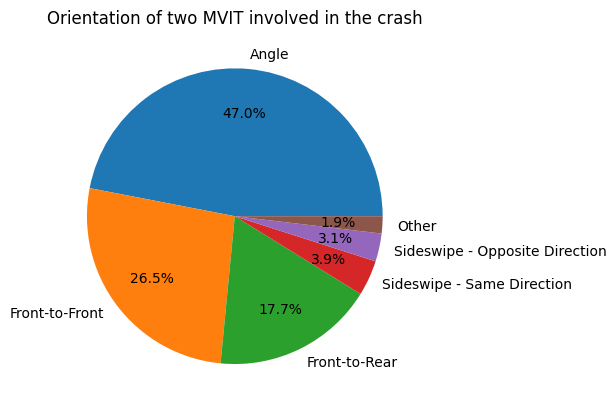

In [60]:
# keep evetns that make at least 3% of total
accManCollDf = accManCollDf[accManCollDf["TotalAccidents"]/totMVinTransportAcc >= 0.03]
accManCollDf.loc["Other"] = [totMVinTransportAcc - accManCollDf["TotalAccidents"].sum()]
_ = accManCollDf["TotalAccidents"].plot.pie(legend = False, title = "Orientation of two MVIT involved in the crash", \
    ylabel = "", autopct="%1.1f%%", pctdistance = 0.7, rotatelabels = False)

In [26]:
# Vehicle Make 
# accidents harmul events
vehModDf = pd.DataFrame(farsDf["vehicle"]["MAKE"].value_counts().sort_values(ascending=False)).head(20)
vehModDf.columns = ["TotalVehicles"]
vehModDf["MAKE"] = vehModDf.index.values
vehModDf["MAKE"] = vehModDf.apply(lambda row: farsCategories["MAKE"][row["MAKE"]],axis=1)
vehModDf.set_index("MAKE",inplace=True)
totalVeh = len(farsDf["vehicle"])
vehModDf.loc["Others"] = [totalVeh - vehModDf["TotalVehicles"].sum()]
vehModDf


,TotalVehicles
MAKE,
Chevrolet,7086
Ford,7057
Toyota,4360
Honda,4192
Dodge,3211
Nissan/Datsun,3003
Harley-Davidson,2147
GMC,1769
Jeep / Kaiser-Jeep / Willys- Jeep,1552


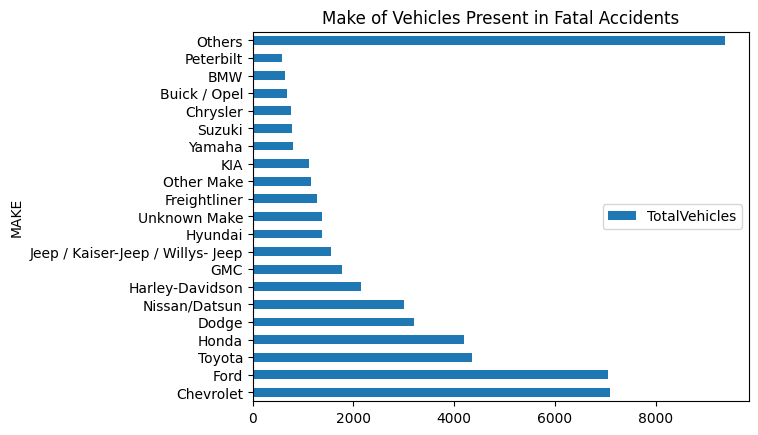

In [27]:
#accTotalsSer = vehModDf.loc["TotalVehicles"]
ax = vehModDf.plot.barh(title = "Make of Vehicles Present in Fatal Accidents")

In [28]:
# Vehicle Model Year
vehYrDf = pd.DataFrame(farsDf["vehicle"]["MOD_YEAR"].value_counts())
vehYrDf.columns = ["TotalVehicles"]
vehYrDf["MOD_YEAR"] = vehYrDf.index.values
#vehYrDf["MAKE"] = vehYrDf.apply(lambda row: farsCategories["MAKE"][row["MAKE"]],axis=1)
#vehYrDf.set_index("MOD_YEAR",inplace=True)
totalVeh = len(farsDf["vehicle"])
#vehYrDf.loc["Others"] = [totalVeh - vehYrDf["TotalVehicles"].sum()]
vehYrDf.loc["Unknown"] = [vehYrDf.loc[9998]["TotalVehicles"] + vehYrDf.loc[9999]["TotalVehicles"],np.NaN]
vehYrDf.drop(index=[9998,9999],inplace=True)
vehYrDf

,TotalVehicles,MOD_YEAR
2016,2868.0,2016.0
2007,2813.0,2007.0
2019,2719.0,2019.0
2015,2666.0,2015.0
2017,2633.0,2017.0
...,...,...
1950,1.0,1950.0
1960,1.0,1960.0
1936,1.0,1936.0
1930,1.0,1930.0


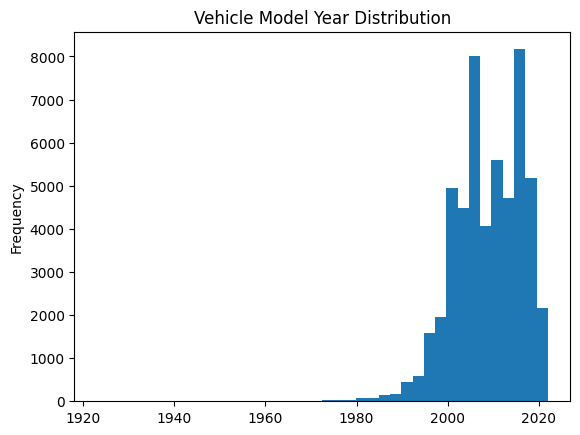

In [29]:
_ = farsDf["vehicle"][farsDf["vehicle"]["MOD_YEAR"] < 9998]["MOD_YEAR"].plot.hist(bins=40,title="Vehicle Model Year Distribution")

Text(0.5, 1.0, 'Vehicle Model Year')

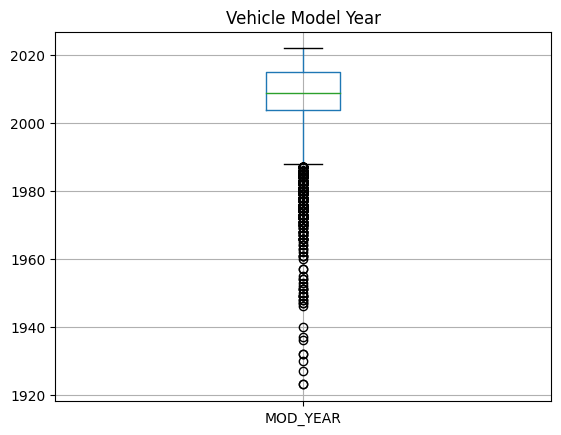

In [30]:
#ax = vehYrDf.boxplot(column="MOD_YEAR")
ax = farsDf["vehicle"][farsDf["vehicle"]["MOD_YEAR"] < 9998].boxplot(column="MOD_YEAR")
ax.set_title("Vehicle Model Year")

In [31]:
# Driver was Drinking
vehDrinkDf = pd.DataFrame(farsDf["vehicle"]["DR_DRINK"].value_counts().sort_values(ascending=False))
vehDrinkDf.columns = ["TotalVehicles"]
vehDrinkDf["DR_DRINK"] = vehDrinkDf.index.values
vehDrinkDf["DR_DRINK"] = vehDrinkDf.apply(lambda row: farsCategories["DR_DRINK"][row["DR_DRINK"]],axis=1)
vehDrinkDf.set_index("DR_DRINK",inplace=True)
totalVeh = len(farsDf["vehicle"])
#vehDrinkDf.loc["Others"] = [totalVeh - vehDrinkDf["TotalVehicles"].sum()]
vehDrinkDf

,TotalVehicles
DR_DRINK,
No,44743
Yes,9529


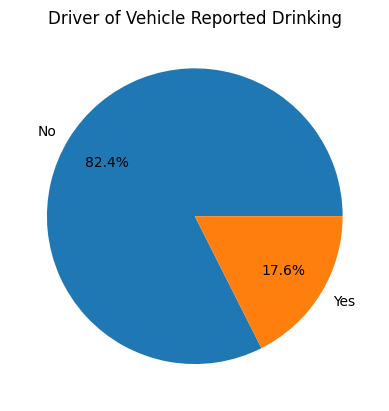

In [32]:
_ = vehDrinkDf["TotalVehicles"].plot.pie(legend = False, title = "Driver of Vehicle Reported Drinking", \
    ylabel = "", autopct="%1.1f%%", pctdistance = 0.7, rotatelabels = False)

In [33]:
# simplify access to driver information from "person" table
driversDf = farsDf["person"][farsDf["person"]["PER_TYP"] == 1]
totalDrivers = len(driversDf)

In [34]:
# Driver's Sex
drSexDf = pd.DataFrame(driversDf["SEX"].value_counts().sort_values(ascending=False))
drSexDf.columns = ["TotalDrivers"]
drSexDf["SEX"] = drSexDf.index.values
drSexDf["SEX"] = drSexDf.apply(lambda row: farsCategories["SEX"][row["SEX"]],axis=1)
drSexDf.set_index("SEX",inplace=True)
# Combine 'Reported as Unknown' and 'Not Reported'
drSexDf.loc["Unknown"] = drSexDf.loc["Reported as Unknown"] + drSexDf.loc["Not Reported"]
drSexDf.drop(index=["Reported as Unknown","Not Reported"],inplace=True)
drSexDf

,TotalDrivers
SEX,
Male,39393
Female,13033
Unknown,1464


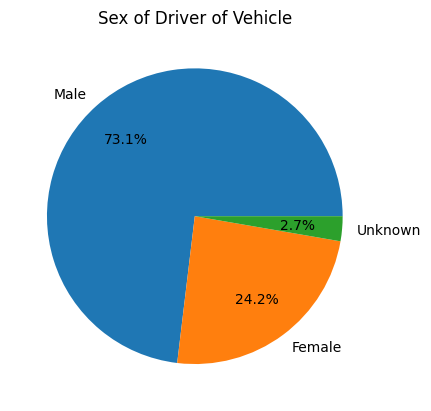

In [35]:
_ = drSexDf["TotalDrivers"].plot.pie(legend = False, title = "Sex of Driver of Vehicle", \
    ylabel = "", autopct="%1.1f%%", pctdistance = 0.7, rotatelabels = False)

In [36]:
# Driver's Age
drAgeDf = pd.DataFrame(driversDf["AGE"].value_counts().sort_index())
drAgeDf.columns = ["TotalDrivers"]
drAgeDf["AGE"] = drAgeDf.index.values
#drAgeDf["SEX"] = drAgeDf.apply(lambda row: farsCategories["SEX"][row["SEX"]],axis=1)
#drAgeDf.set_index("AGE",inplace=True)
# Combine 'Reported as Unknown' and 'Not Reported'
drAgeDf.loc["Unknown"] = [drAgeDf.loc[998]["TotalDrivers"] + drAgeDf.loc[999]["TotalDrivers"],np.NaN]
drAgeDf.drop(index=[998,999],inplace=True)
drAgeDf

,TotalDrivers,AGE
7,2.0,7.0
8,2.0,8.0
9,1.0,9.0
10,5.0,10.0
11,3.0,11.0
...,...,...
98,1.0,98.0
99,4.0,99.0
100,1.0,100.0
102,1.0,102.0


In [37]:
drAgeDf["AGE"].describe()

count     95.000000
mean      54.010526
std       27.586419
min        7.000000
25%       30.500000
50%       54.000000
75%       77.500000
max      102.000000
Name: AGE, dtype: float64

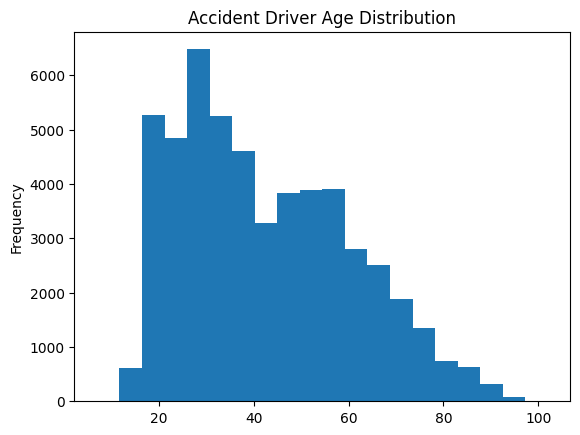

In [38]:
#_ = drAgeDf.drop(index="Unknown").plot.hist(by="TotalDrivers")
_ = driversDf[driversDf["AGE"] < 998]["AGE"].plot.hist(bins=20,title="Accident Driver Age Distribution")

Text(0.5, 0.98, '')

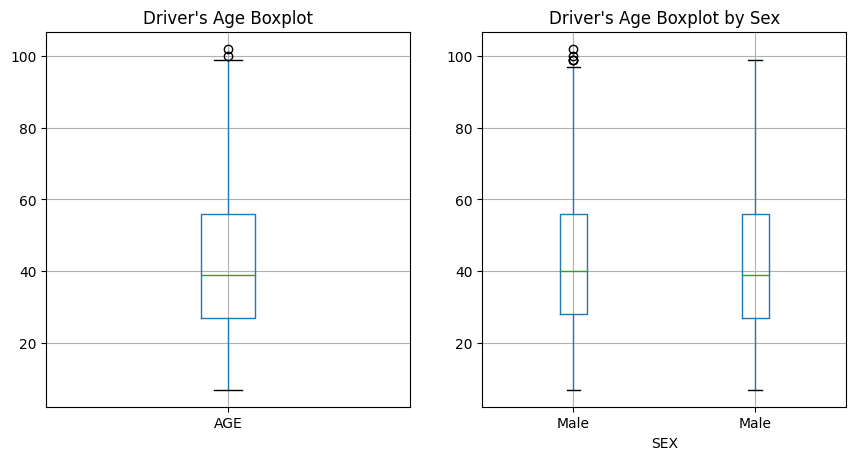

In [88]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
driversDf[driversDf["AGE"] < 998].boxplot(column="AGE",ax=ax1)
ax1.set_title("Driver's Age Boxplot")
driversDf[(driversDf["AGE"] < 998) & (driversDf["SEX"].isin([1,2]))].boxplot(column="AGE",by="SEX",ax=ax2)
ax2.set_title("Driver's Age Boxplot by Sex")
ax2.set_xticklabels([farsCategories["SEX"][1],farsCategories["SEX"][1]])
fig.suptitle("")


# NYS DMV Data Verification

In [40]:
nydmvDf.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12586701 entries, 0 to 12586700
Data columns (total 20 columns):
 #   Column                Non-Null Count     Dtype  
---  ------                --------------     -----  
 0   Record Type           12586701 non-null  object 
 1   VIN                   12586515 non-null  object 
 2   Registration Class    12586701 non-null  object 
 3   City                  12586701 non-null  object 
 4   State                 12586701 non-null  object 
 5   Zip                   12586701 non-null  int64  
 6   County                12586701 non-null  object 
 7   Model Year            12586677 non-null  float64
 8   Make                  12586691 non-null  object 
 9   Body Type             12586701 non-null  object 
 10  Fuel Type             12567068 non-null  object 
 11  Unladen Weight        9695237 non-null   float64
 12  Maximum Gross Weight  2271426 non-null   float64
 13  Passengers            221924 non-null    float64
 14  Reg Valid Date  

In [41]:
nydmvDf = nydmvDf[nydmvDf["Record Type"] == "VEH"]
nydmvDf.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11350911 entries, 2 to 12586700
Data columns (total 20 columns):
 #   Column                Non-Null Count     Dtype  
---  ------                --------------     -----  
 0   Record Type           11350911 non-null  object 
 1   VIN                   11350905 non-null  object 
 2   Registration Class    11350911 non-null  object 
 3   City                  11350911 non-null  object 
 4   State                 11350911 non-null  object 
 5   Zip                   11350911 non-null  int64  
 6   County                11350911 non-null  object 
 7   Model Year            11350911 non-null  float64
 8   Make                  11350909 non-null  object 
 9   Body Type             11350911 non-null  object 
 10  Fuel Type             11350911 non-null  object 
 11  Unladen Weight        9566909 non-null   float64
 12  Maximum Gross Weight  1561939 non-null   float64
 13  Passengers            221924 non-null    float64
 14  Reg Valid Date  

In [42]:
# Set categorical variables
nydmvDf["State"] = nydmvDf["State"].astype('category')
nydmvDf["Make"] = nydmvDf["Make"].astype('category')
nydmvDf["Body Type"] = nydmvDf["Body Type"].astype('category')
nydmvDf["Fuel Type"] = nydmvDf["Fuel Type"].astype('category')
nydmvDf.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11350911 entries, 2 to 12586700
Data columns (total 20 columns):
 #   Column                Non-Null Count     Dtype   
---  ------                --------------     -----   
 0   Record Type           11350911 non-null  object  
 1   VIN                   11350905 non-null  object  
 2   Registration Class    11350911 non-null  object  
 3   City                  11350911 non-null  object  
 4   State                 11350911 non-null  category
 5   Zip                   11350911 non-null  int64   
 6   County                11350911 non-null  object  
 7   Model Year            11350911 non-null  float64 
 8   Make                  11350909 non-null  category
 9   Body Type             11350911 non-null  category
 10  Fuel Type             11350911 non-null  category
 11  Unladen Weight        9566909 non-null   float64 
 12  Maximum Gross Weight  1561939 non-null   float64 
 13  Passengers            221924 non-null    float64 
 14  

In [43]:
nydmvDf.describe()

,Zip,Model Year,Unladen Weight,Maximum Gross Weight,Passengers
count,1.135091e+07,1.135091e+07,9.566909e+06,1.561939e+06,221924.000000
mean,1.270068e+04,2.012962e+03,4.123404e+03,8.996256e+03,9.484869
std,4.961370e+03,9.149883e+00,5.925678e+03,1.087036e+04,11.013074
min,0.000000e+00,1.900000e+03,1.000000e+00,5.000000e+00,1.000000
25%,1.123600e+04,2.009000e+03,3.173000e+03,4.916000e+03,5.000000
50%,1.195000e+04,2.015000e+03,3.532000e+03,5.500000e+03,5.000000
75%,1.350100e+04,2.019000e+03,4.189000e+03,8.900000e+03,7.000000
max,9.999900e+04,2.024000e+03,9.660000e+05,7.250010e+05,862.000000


In [44]:
nydmvDf["State"].value_counts()

NY    11206294
OK       30539
NJ       29119
IL       15401
MD       12949
        ...   
TA           1
PK           1
YH           1
S            1
YY           1
Name: State, Length: 82, dtype: int64

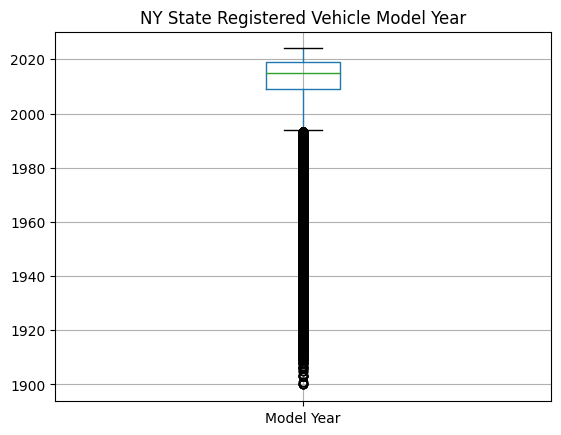

In [45]:
ax = nydmvDf.boxplot(column="Model Year")
_ = ax.set_title("NY State Registered Vehicle Model Year")

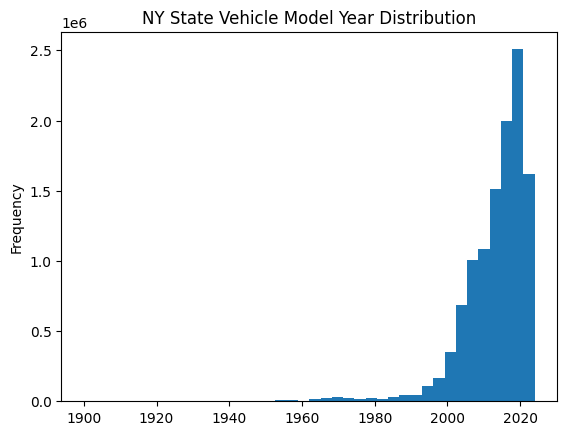

In [46]:
_ = nydmvDf["Model Year"].plot.hist(bins=40,title="NY State Vehicle Model Year Distribution")

In [47]:
# Vehicle Make 
# accidents harmul events
nysVehMake = pd.DataFrame(nydmvDf["Make"].value_counts().sort_values(ascending=False)).head(20)
nysVehMake.columns = ["TotalVehicles"]
#nysVehMake["Make"] = vehModDf.index.values
#nysVehMake.set_index("Make",inplace=True)
totalNYVeh = len(nydmvDf)
nysVehMake.loc["Others"] = [totalNYVeh - nysVehMake["TotalVehicles"].sum()]
nysVehMake

,TotalVehicles
TOYOT,1287162
HONDA,1237490
CHEVR,1198927
FORD,1184186
NISSA,687168
JEEP,609702
SUBAR,510668
HYUND,412515
DODGE,312955
BMW,291507


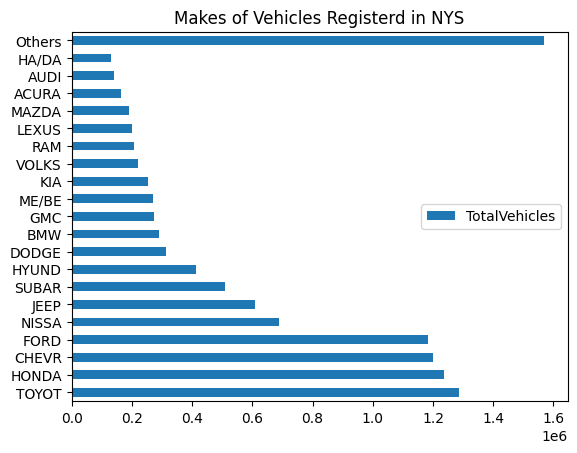

In [48]:
ax = nysVehMake.plot.barh(title = "Makes of Vehicles Registerd in NYS")